In [1]:
import pandas as pd
# pd.options.mode.chained_assignment = None  # default='warn'
import datetime
import random
import importlib
import os
import sys
import json
import time
import importlib
import math
import numpy as np
import pickle as pickle
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
from sklearn.cluster import KMeans
import networkx as nx

In [2]:
list_of_ratings_per_cluster_per_incident_dir  =  "../data/rating/LARGEWINDOW_100"
files_25_ratings = os.listdir(list_of_ratings_per_cluster_per_incident_dir)

In [3]:
# term1 = (1/(math.sqrt(2*3.1415)*std_dr.iloc[i,0]))
# term2 =(-1* math.pow((x.iloc[i,j]-M_BR),2))
# term3 = (2*math.pow(std_dr.iloc[i,0],2))
# if(term1 == 0):
#     print("term2 is the problem")
# #                 term1 = 1
# if(term2 == 0):
#     print("term2 is the problem")
# #                 term2 = 1 
# if(term3 == 0):
#     print("term3 is the problem")
# #                 term3 = 1
# term4 = (math.exp(term2/term3 ))         
# cw.iloc[i,j]  = term1 * term4

def cal_trust_score(file_path):
    rating_A = pd.read_csv(file_path)
#     print(rating_A)
    l_original = rating_A.drop(rating_A.columns[0], axis=1)
#     print(l_original)
    N  = len(l_original)
    Window = len(l_original.columns)
    temp = np.zeros(shape=(N,Window))
    x = pd.DataFrame(temp)
    cw = x.copy()
    w = x.copy()
    K = 4
    eeta = 2;
    M_BR = 4
    l1_original = l_original.apply(np.sort, axis = 1)
#     print(l1_original)
    for i in range(N):
        for j in range(Window):
            x.iloc[i,j] = 1 + ((K-1)*j)/Window
#     print(x)
    temp1 = np.zeros(shape=N)
    std_dr = pd.DataFrame(temp1)
    for i in range(N):
        std_dr.iloc[i] = np.std(l1_original[i])    
    for i in range(len(std_dr)):
        if int(std_dr.iloc[i]) == 0:
            std_dr.iloc[i] = np.mean(std_dr) 
#     print(std_dr)
    for i in range(N):
        for j in range(Window):         
            cw.iloc[i,j] = (1/(math.sqrt(2*3.1415)*std_dr.iloc[i,0]))*(math.exp((-1*math.pow((x.iloc[i,j]-M_BR),2))/(2*math.pow(std_dr.iloc[i,0],2))))
#     print(cw)  
    for i in range(N):
        for j in range(Window):
            w.iloc[i,j] = cw.iloc[i,j]/np.sum(cw.iloc[i,:])
#     print(w)  
    R = np.zeros(shape=N)
    for segment in range(N):
        temp2 = np.zeros(shape=(4,Window))
        I = pd.DataFrame(temp2)
        #creates the evasion discrete levels.
        for j in range(Window):
            if l_original.iloc[segment,j] == 1:
                I.iloc[0,j] = 1
            elif l_original.iloc[segment,j] == 2:
                I.iloc[1,j] = 1
            elif l_original.iloc[segment,j] == 3:
                I.iloc[2,j] = 1
            else:
                I.iloc[3,j] = 1
        temp3 = np.zeros(shape=4)
        wd = pd.DataFrame(temp3)
        for i in range(4):
            for j in range(Window):
                wd.iloc[i,0] = wd.iloc[i,0] + I.iloc[i,j]*w.iloc[segment,j]

        for i in range(4):
            R[segment] = R[segment] + (i+1)*wd.iloc[i,0]
#     print(R)
    TR = np.zeros(shape=N)
    for i in range(N):
        TR[i] = (1/math.pow(K,eeta))*(math.pow(R[i],eeta))
#     print(TR)
    return TR,rating_A.iloc[:, 0].tolist()


In [4]:
trust_score=[]
prediction =[] #0 means high trusted 1 means less trusted 
segment_list_per_cluster = []
for file_path in files_25_ratings:
    print(file_path)
    fp = os.path.join(list_of_ratings_per_cluster_per_incident_dir, file_path)
    TR,list_segments = cal_trust_score(fp)
    trust_score.append(TR)
    segment_list_per_cluster.append(list_segments)
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(TR.reshape(-1,1))
    y_kmeans = kmeans.predict(TR.reshape(-1,1))
    prediction.append(y_kmeans)
    print(TR)
    print(y_kmeans)
    break

LARGEWINDOW_1524274521_20191018170000_20191018175500_ratings.csv


/Users/jaminurislam/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


[1.         1.         1.         0.99976659 1.         1.
 1.         0.07752832 1.         1.         1.         1.
 1.         1.         0.99950296 1.         1.         1.
 1.         1.         1.         1.         1.         0.91549942
 1.         1.         1.         1.         0.08509551 1.
 1.         1.         1.         1.         1.         0.91609817
 1.         0.99928444 1.         1.         0.08490463 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.08698445 1.         1.
 1.         0.08806766 1.         1.         1.         1.
 0.99910853 0.9146067  1.         1.         1.         1.
 0.99999926 1.         1.         1.         0.92964825 1.
 0.93297469 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.09516418 0.88976272 0.99831967
 1.         1.         0.89618972 1.         0.09137629 1.
 1.         1.         1.       

In [6]:
def get_neighboring_segments(G, cluster_list, segment, level=5, undirected=False):
    neighbor_df = {'XDSegID': [], 'level': []}
    done = []
    for l in range(level + 1):
        H = nx.ego_graph(L_XDSegID, n=segment, radius=l, undirected=undirected)
        for n in H.nodes:
            if n not in done:
                if n in cluster_list:
#                     print(n, l)
                    neighbor_df['XDSegID'].append(n)
                    neighbor_df['level'].append(l)
                    done.append(n)
    return pd.DataFrame(neighbor_df).sort_values(by='level')

In [9]:
if not os.path.exists(os.path.join(os.getcwd(), '../data')):
    raise OSError("Must first download data, see README.md")
data_dir = os.path.join(os.getcwd(), '../data')

if not os.path.exists(os.path.join(data_dir, 'segment_network_graphs')):
    os.mkdir(os.path.join(data_dir, 'segment_network_graphs'))
graphs_dir = os.path.join(data_dir, 'segment_network_graphs')
fp = os.path.join(graphs_dir, 'line_segment_graph.gml')
L_XDSegID = nx.read_gml(fp, destringizer=int)
print(nx.info(L_XDSegID))

MultiDiGraph with 6906 nodes and 15264 edges


/var/folders/k3/yr6xqkcd6dx_w09lmqq7y7h80000gn/T/ipykernel_44274/572548672.py:10: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(L_XDSegID))


In [10]:
ground_truth_data_path  =  "../data/generated_clusters/maxr085_incident_ratios/incidents_GT"
files_GT = os.listdir(ground_truth_data_path)
incident_GT = []
i = 0
while i< len(files_GT):
    fp = os.path.join(ground_truth_data_path, files_GT[i])
    with open(fp, 'rb') as handle:
        incident_GT.append( pickle.load(handle))
    i+=1
incident_GT_Frame = pd.concat(incident_GT)

In [11]:
fp_cluster = '../data/generated_clusters/optimized_clustering_0.7_0.85_maxr085_restricted.pkl'

# optimized_clustering_0.7_0.85_maxr085_restricted.pkl
# used_clusters_list_maxr085_25C_10-21-2021.pkl
with open(fp_cluster, 'rb') as handle:
    cluster_list = pickle.load(handle)

In [12]:
neighbour_segments_per_incident_per_cluster = []
list_of_cluster = []
for i in range(0,len(files_25_ratings)): 
#     160836160_20191130115000_20191130121500_ratings.csv
#     print(files_25_ratings[i])
    base = len("LARGEWIND0_") + 1
    cluster_head = files_25_ratings[i][base:base+10]
    if(cluster_head.isnumeric() == True):
        month = files_25_ratings[i][base+15:base+17]
        day = files_25_ratings[i][base+17:base+19]
    else:
        cluster_head = files_25_ratings[i][base:base+9]
        month = files_25_ratings[i][base+14:base+16]
        day = files_25_ratings[i][base+16:base+18]
    list_of_cluster.append(cluster_head)
#     start_hour = files_25_ratings[i][19:21]
#     start_minute = files_25_ratings[i][21:23]
#     end_hour = files_25_ratings[i][34:36]
#     end_minute = files_25_ratings[i][36:38]
#     print(cluster_head,', ', month,' ,',day,',')#start_hour,',',start_minute,',',end_hour,',',end_minute)
#     print(cluster_head)
    incident_segment_frame = incident_GT_Frame[(incident_GT_Frame['cluster_head'] == int(cluster_head)) &\
                         ((incident_GT_Frame.index.month == int(month))&( incident_GT_Frame.index.day==int(day)))]
#     print(incident_segment_frame)
    if(len(incident_segment_frame) == 0): 
        continue
    segment_to_check = incident_segment_frame['XDSegID'].tolist()[0]
#     print(segment_to_check)
    level = 4
    neighbour_segments = get_neighboring_segments(L_XDSegID, cluster_list[int(cluster_head)], segment_to_check, level, undirected=True)
#     neighbour_segments2 = get_neighboring_segments(L_XDSegID, cluster_list[int(cluster_head)], segment_to_check, level, undirected=False)
#     neighbour_segments = pd.concat([neighbour_segments1,neighbour_segments1])
    neighbour_segments_per_incident_per_cluster.append(neighbour_segments)

In [13]:
len(neighbour_segments_per_incident_per_cluster)

99

In [14]:
success_rate_sum = 0
success_count = 0
for fI in range(0,len(files_25_ratings)):
    TR_prediction = prediction[fI]
#     print('*************',list_of_cluster[fI],'***************')

#     print(TR_prediction)
    neighbour_segments_frame =  neighbour_segments_per_incident_per_cluster[fI]
    neighbour_segments_list = neighbour_segments_frame['XDSegID'].tolist()
#     print(neighbour_segments_list)
    segment_list = segment_list_per_cluster[fI]
#     print(len(segment_list))
#     print(len(TR_prediction))
#     print( neighbour_segments_frame[neighbour_segments_frame['level']== 1])
#     actual_affected_segment_count = neighbour_segments_frame[neighbour_segments_frame['level']== 1]['XDSegID'].count()
#     print("Actual affected segment count for ",fI,"-th Cluster is: ",actual_affected_segment_count)
#     if(actual_affected_segment_count == 0):
#         print(fI,"th segment has count zero",actual_affected_segment_count)
#     predicted_affected_segment_count = 0
    for i in range(0,len(TR_prediction)):
        if(TR_prediction[i] == 1 ):
            if(segment_list[i]  in neighbour_segments_list ):
#                 print(neighbour_segments_frame[neighbour_segments_frame['XDSegID']==segment_list[i]]['level'].tolist())
                label = neighbour_segments_frame[neighbour_segments_frame['XDSegID']==segment_list[i]]['level'].tolist()[0]
#                 print(segment_list[i],':',label)
                if((label == int(1))or(label == int(0))) :
#                     predicted_affected_segment_count = predicted_affected_segment_count + 1
                    success_count = success_count + 1
                    break

#     success_rate = predicted_affected_segment_count/actual_affected_segment_count
#     if(math.isnan(success_rate) == False):
#         success_rate_sum = success_rate_sum + success_rate
#         print(success_rate,predicted_affected_segment_count,actual_affected_segment_count)
#     break
# print(success_rate_sum)
avg_success_rate = success_count/(len(files_25_ratings))
print(avg_success_rate)

0.7070707070707071


/var/folders/k3/yr6xqkcd6dx_w09lmqq7y7h80000gn/T/ipykernel_44274/1850606670.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(segment_list_per_cluster[i], rotation=90)


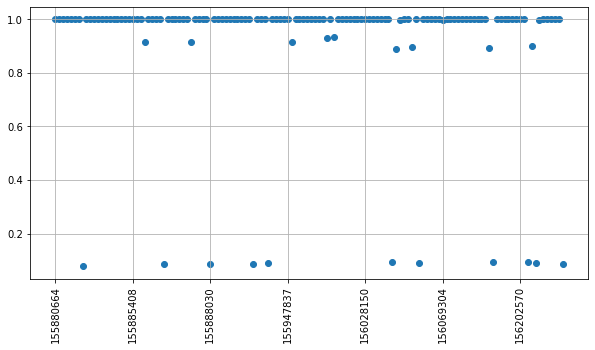

In [16]:
for i, file_path in enumerate(files_25_ratings):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(x=range(len(segment_list_per_cluster[i])), y=trust_score[i], marker='o')
    
    # Uncomment to not show all segment labels
#     ax.set_xticks(np.arange(len(segment_list_per_cluster[i])))
    ax.set_xticklabels(segment_list_per_cluster[i], rotation=90)
    ax.grid()
    break

# Below not needed 

In [41]:
for fI in range(0,len(files_25_ratings)):
    print('*************',list_of_cluster[fI],'***************')
    TC = trust_score[fI]
    TR_prediction = prediction[fI]
    segment_list = segment_list_per_cluster[fI]
    for i in range(0,len(TR_prediction)):
        if(TR_prediction[i] == 1 ):
            if(segment_list[i]  in neighbour_segments_list ):
                label = neighbour_segments_frame[neighbour_segments_frame['XDSegID']==segment_list[i]]['level'].tolist()[0]
                print("segment: ",segment_list[i]," Trust Score: ",TC[i],' Level: ',label)


************* 1524274521 ***************
************* 1524274521 ***************
************* 1524274521 ***************
************* 1524274521 ***************
************* 1524373007 ***************
************* 1524373007 ***************
************* 1524373007 ***************
************* 1524373007 ***************
************* 1524373007 ***************
************* 1524373007 ***************
************* 1524393544 ***************
************* 1524393544 ***************
************* 1524393544 ***************
************* 1524393544 ***************
************* 1524393544 ***************
************* 1524394465 ***************
************* 1524394465 ***************
************* 1524394465 ***************
************* 1524394465 ***************
************* 1524402419 ***************
************* 1524402419 ***************
************* 1524402419 ***************
************* 1524423643 ***************
************* 1524423643 ***************
************* 15

In [15]:
success_rate_sum = 0
for fI in range(0,len(files_25_ratings)):
    TC = trust_score[fI]
    TR_prediction = prediction[fI]
    print('*************',list_of_cluster[fI],'***************')

#     print(TR_prediction)
    neighbour_segments_frame =  neighbour_segments_per_incident_per_cluster[fI]
    neighbour_segments_list = neighbour_segments_frame['XDSegID'].tolist()
#     print(neighbour_segments_list)
    segment_list = segment_list_per_cluster[fI]
#     print(len(segment_list))
#     print(len(TR_prediction))
#     print( neighbour_segments_frame[neighbour_segments_frame['level']== 1])
    actual_affected_segment_count = neighbour_segments_frame[neighbour_segments_frame['level']== 1]['XDSegID'].count()
#     print("Actual affected segment count for ",fI,"-th Cluster is: ",actual_affected_segment_count)
    if(actual_affected_segment_count == 0):
        print(fI,"th segment has count zero",actual_affected_segment_count)
    predicted_affected_segment_count = 0
    for i in range(0,len(TR_prediction)):
        if(TR_prediction[i] == 1 ):
            if(segment_list[i]  in neighbour_segments_list ):
#                 print(neighbour_segments_frame[neighbour_segments_frame['XDSegID']==segment_list[i]]['level'].tolist())
                label = neighbour_segments_frame[neighbour_segments_frame['XDSegID']==segment_list[i]]['level'].tolist()[0]
#                 print(segment_list[i],':',label)
                print("segment: ",segment_list[i]," Trust Score: ",TC[i],' Level: ',label)

                if(label == int(1)):
                    predicted_affected_segment_count = predicted_affected_segment_count + 1
    success_rate = predicted_affected_segment_count/actual_affected_segment_count
    if(math.isnan(success_rate) == False):
        success_rate_sum = success_rate_sum + success_rate
        print(success_rate,predicted_affected_segment_count,actual_affected_segment_count)
#     break
# print(success_rate_sum)
avg_success_rate = success_rate_sum/(len(files_25_ratings))
print(avg_success_rate)

************* 1524274521 ***************
1524428760 : 4
1524639049 : 4
0.0 0 3
************* 1524373007 ***************
449617457 : 4
449617581 : 3
1524260889 : 3
1524326614 : 3
1524326639 : 4
1524329182 : 3
1524333864 : 2
1524336723 : 3
1524338419 : 3
1524363122 : 4
1524372460 : 4
1524372603 : 4
1524552636 : 2
0.0 0 4
************* 1524393544 ***************
429334038 : 3
449626432 : 4
1524393684 : 1
1524471115 : 2
0.3333333333333333 1 3
************* 1524394465 ***************
1524308373 : 3
1524338317 : 2
1524379735 : 1
1524447216 : 3
1524451240 : 2
1524490899 : 1
1524507268 : 3
0.6666666666666666 2 3
************* 1524402419 ***************
449628627 : 3
449628630 : 2
449628632 : 1
449628637 : 0
0.3333333333333333 1 3
************* 1524423643 ***************
156189502 : 4
156428657 : 3
429334638 : 4
429334640 : 2
429334642 : 2
429334643 : 3
429334645 : 3
429334646 : 4
429334647 : 3
449626504 : 0
449626565 : 1
449626566 : 2
449626567 : 3
449626600 : 4
449626601 : 3
1524261565 : 4
15

C:\Users\jami1\anaconda3\envs\detection\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in longlong_scalars


In [16]:
18/25

0.72

In [ ]:
check the trust score that has level 0,1,2 with level 3,4 